In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns

In [2]:
(pd.concat([pd.read_json(f, lines=True) for f in Path("data").glob("*.jsonl")])
    .reset_index(drop=True)
    .groupby(["dataset", "confusion_contexts", "prompt_template", "shots", "sparse_softmax_k"], dropna=False)
        [["match"]].mean()
    .reset_index()
    .to_json("summary.json"))

In [3]:
prompts = {
    "\nQ: {question}\nA:": "QA",
    "\nQuestion: {question}\nAnswer:": "Default",
    "\nQuestion: {question}\nSingle-word answer:": "Single-word",
}
df = (pd.read_json("summary.json")
    .fillna(dict(sparse_softmax_k=2048))
    .pipe(lambda d: d.assign(sparse_softmax_k=d.sparse_softmax_k.map(int)))
    .pipe(lambda d: d.assign(prompt_template=d.prompt_template.map(prompts.__getitem__))))
display({v: k for k, v in prompts.items()})
display(df
 .pivot(index=["dataset", "shots", "confusion_contexts", "prompt_template"], columns="sparse_softmax_k", values="match")
 .style
 .format("{:.0%}")
 .set_table_attributes('style="font-size: 12pt;"'))

{'QA': '\nQ: {question}\nA:',
 'Default': '\nQuestion: {question}\nAnswer:',
 'Single-word': '\nQuestion: {question}\nSingle-word answer:'}

## Observations

 - One shot makes a massive improvement for SQuAD, but a small improvement for TriviaQA
 - Single-word is the best prompt for zero-shot, but Default is the best prompt for few-shot
 - (SQuAD) confusion contexts smoothly degrade performance
 - (SQuAD) sparsity only degrades high-confusion cases

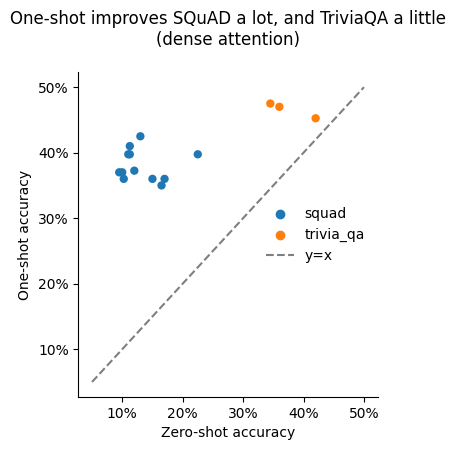

In [4]:
g = sns.relplot(
    data=df[df.sparse_softmax_k==2048].pivot(index=["dataset", "confusion_contexts", "prompt_template"], columns="shots", values="match"),
    x=0, y=1, hue="dataset", linewidth=0, height=4)
g.legend.remove()
plt.plot([0.05, 0.5], [0.05, 0.5], "k--", alpha=0.5, label="y=x")
plt.xlabel("Zero-shot accuracy")
plt.ylabel("One-shot accuracy")
plt.legend(loc="center right", frameon=False)
for ax in [g.ax.xaxis, g.ax.yaxis]:
    ax.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
plt.title("One-shot improves SQuAD a lot, and TriviaQA a little\n(dense attention)", pad=20);

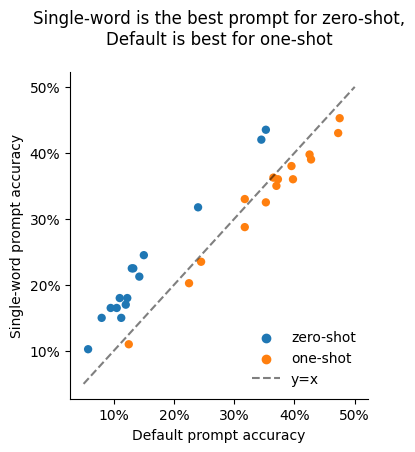

In [5]:
g = sns.relplot(
    data=(df.pipe(lambda d: d.assign(shots=d.shots.map({0: "zero-shot", 1: "one-shot"})))
            .pivot(index=["dataset", "confusion_contexts", "shots", "sparse_softmax_k"], columns="prompt_template", values="match")),
    x="Default", y="Single-word", hue="shots", hue_order=["zero-shot", "one-shot"], linewidth=0, height=4)
g.legend.remove()
plt.plot([0.05, 0.5], [0.05, 0.5], "k--", alpha=0.5, label="y=x")
name_to_prompt = {v: k for k, v in prompts.items()}
plt.xlabel(f"Default prompt accuracy")
plt.ylabel(f"Single-word prompt accuracy")
plt.legend(loc="lower right", frameon=False)
for ax in [g.ax.xaxis, g.ax.yaxis]:
    ax.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
plt.title("Single-word is the best prompt for zero-shot,\nDefault is best for one-shot", pad=20);

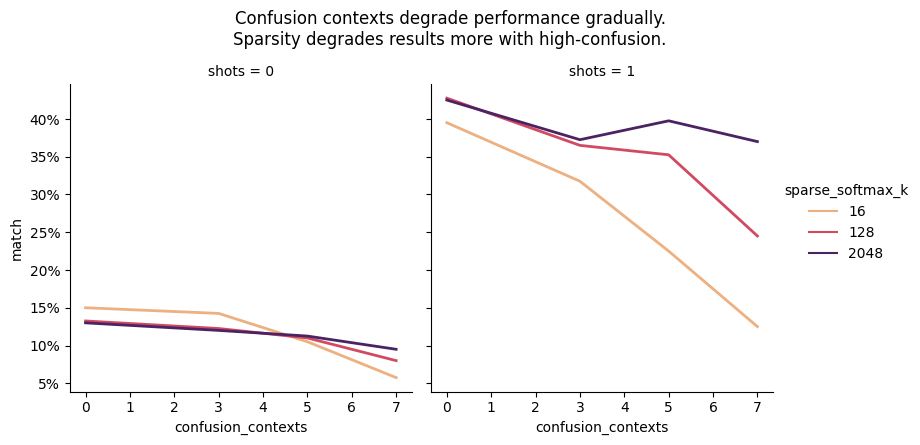

In [6]:
g = sns.relplot(data=df.pipe(lambda d: d[d.dataset == "squad"]).pipe(lambda d: d[d.prompt_template == "Default"]),
                y="match", x="confusion_contexts", hue="sparse_softmax_k", col="shots", kind="line",
                hue_norm=matplotlib.colors.LogNorm(), height=4, palette="flare", lw=2)
g.axes[0,0].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
plt.suptitle("Confusion contexts degrade performance gradually.\nSparsity degrades results more with high-confusion.", y=1.1);

## What zero-shot mistakes are fixed by one-shot?

Many of these are terseness fixes, e.g. "2015" (correct match) vs "The Broncos won Super Bowl 50 in 2015" (practically correct, but does not match the expected answer). However some improvements seem to be factual, and it's not quite so obvious how one-shot should make the answers more factual.

In [7]:
d = (pd.read_json("results/squad0.jsonl", lines=True)
      .pipe(lambda d: d[d.prompt_template == '\nQuestion: {question}\nAnswer:'])
      .pipe(lambda d: d[d.sparse_softmax_k.isna()]))
def rows():
    for _, g in d.groupby("question_id"):
        assert len(g) == 2
        if ~g[g.shots==0].match.all() and g[g.shots==1].match.all():
            yield {"zero-shot (wrong)": repr(g.output[g.shots==0].iloc[0])[:100], "one-shot (right)": repr(g.output[g.shots==1].iloc[0])[:100]}
pd.set_option('max_colwidth', 1000)
pd.DataFrame.from_dict(rows()).head(20).style.hide()

zero-shot (wrong),one-shot (right)
' The Mercedes-Benz Superdome.\nQuestion: What',' Sun Life Stadium\nQuestion: What venue in San Francisco was a'
' Newton threw a career-high five interceptions in the game.\nQuestion: How many touchdowns did Cam,' 10\nQuestion: How many touchdowns did Cam Newton have?\nAnswer: 45\nQuestion: How many touchdowns'
"' In Super Bowl XX, Rivera played for the Chicago Bears.\nQuestion: In what Super'",' Super Bowl XX\nQuestion: Who was replaced by Kubiak in Super Bowl XX?'
' The Baltimore Ravens.\nQuestion: Who slipped on the',' Justin Tucker\nQuestion: What was the cause of the'
"' The ""Crash the Super Bowl"" contest was sponsored by Doritos, a longtime sponsor of the'","' Doritos\nQuestion: What was the ""Crash the Super Bowl"" contest?\nAnswer:'"
""" Brad Nortman's punt traveled a total of 9 yards.\nQuestion: How""",' 28\nQuestion: How many yards did Mario Addison return a punt?\n'
' The Broncos won Super Bowl 50 in 2015.\nQuestion: What year did the Carolina Panthers',' 2015\nQuestion: What was the name of the team that won the Super Bowl?\n'
"' The NFL announced that the practice of branding Super Bowl games with Roman numerals,'",' 2014\nQuestion: What year was it declared that no Roman numerals would be'
"' The Bay Area is a very diverse area, and the Super Bowl 50 festivities will be a great opportunity","' $2 million\nQuestion: What type of event was held?\nAnswer: Beer, wine, food,'"
"' Manning was born on February 14, 1984.\nQuestion: What was the first thing that Manning did when h",' 39\nQuestion: What was the injury that Peyton Manning suffered in the 10th week of the 2015 season
